###Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import random
import pickle
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

# Set random seed for reproducibility
np.random.seed(0)

###Load the GTSRB Dataset

In [2]:
# Load data
with open('/content/drive/MyDrive/Projects/Traffic_Sign_Classification/GTSRB_dataset/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('/content/drive/MyDrive/Projects/Traffic_Sign_Classification/GTSRB_dataset/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('/content/drive/MyDrive/Projects/Traffic_Sign_Classification/GTSRB_dataset/test.p', 'rb') as f:
    test_data = pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

###Data Summary and Exploration

In [3]:
# Dataset info

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [4]:
data = pd.read_csv('/content/drive/MyDrive/Projects/Traffic_Sign_Classification/GTSRB_dataset/signnames.csv')
num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(6,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + " - " + row["SignName"])
            num_of_samples.append(len(x_selected))

Output hidden; open in https://colab.research.google.com to view.

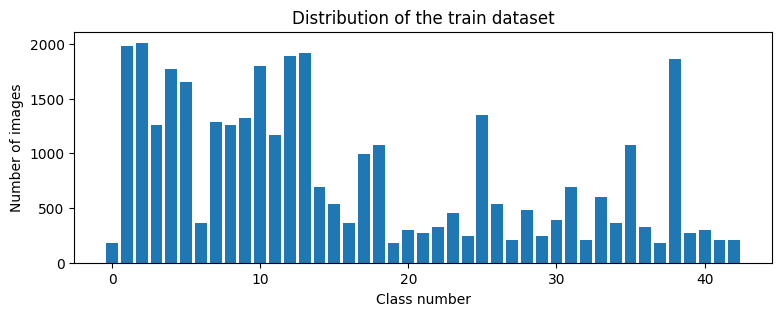

In [5]:
plt.figure(figsize=(9, 3))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

###Image Preprocessing

In [6]:
# Preprocessing
def grayscale(img):
  return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def equalize(img):
  return cv2.equalizeHist(img)

def preprocess(img):
  return equalize(grayscale(img)) / 255

X_train = np.array(list(map(preprocess, X_train))).reshape(-1, 32, 32, 1)
X_val = np.array(list(map(preprocess, X_val))).reshape(-1, 32, 32, 1)
X_test = np.array(list(map(preprocess, X_test))).reshape(-1, 32, 32, 1)

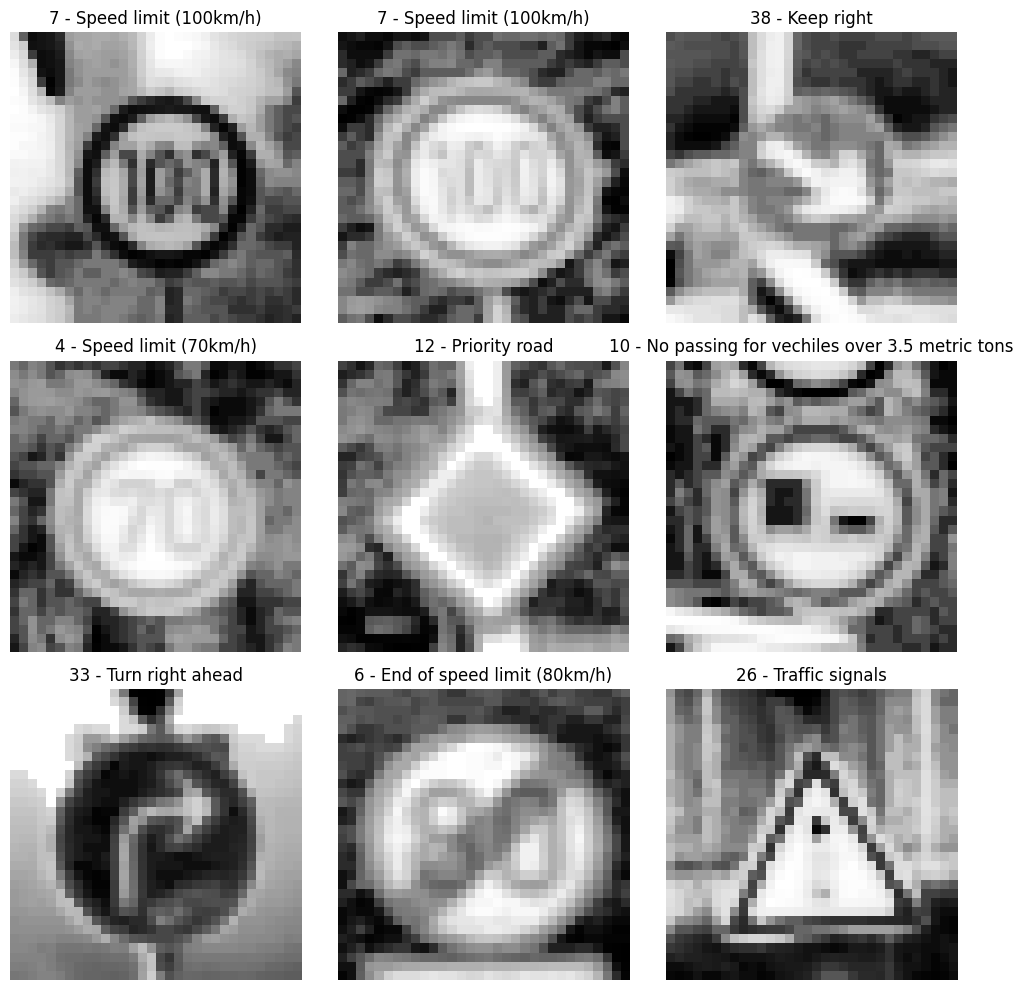

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.ravel()

for i in range(9):
  index = random.randint(0, len(X_train) - 1)
  img = X_train[index]
  axs[i].imshow(img.squeeze(), cmap='gray')
  axs[i].set_title(f"{y_train[index]} - {data.loc[y_train[index], 'SignName']}")
  axs[i].axis('off')

plt.tight_layout()
plt.show()

###One-Hot Encode Labels

In [8]:
# One-hot encoding
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

###Data Augmentation

In [9]:
# Data Augmentation
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10.
)
datagen.fit(X_train)
train_generator = datagen.flow(X_train, y_train, batch_size=50, shuffle=True)

###Build CNN Model


In [10]:
# Model Architecture
def create_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), activation='relu', input_shape=(32, 32, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))

    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

In [11]:
model = create_model()
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 60)     │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 60)     │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 10, 30)     │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 30)       │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,743 (1.44 MB)

 Trainable params: 378,383 (1.44 MB)

 Non-trainable params: 360 (1.41 KB)

None


###Setup Callbacks

In [12]:
# Callbacks

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_path = "/content/drive/MyDrive/Projects/Traffic_Sign_Classification/best_model.h5"
model_ckpt = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)

###Train the Model

In [13]:
# Training
history = model.fit(
    train_generator,
    steps_per_epoch=X_train.shape[0] // 50,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, model_ckpt]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


694/695 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - categorical_accuracy: 0.4526 - loss: 2.0545

695/695 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - categorical_accuracy: 0.4532 - loss: 2.0522 - val_categorical_accuracy: 0.9043 - val_loss: 0.3097
Epoch 2/50
  1/695 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - categorical_accuracy: 0.8800 - loss: 0.2404

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


695/695 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step - categorical_accuracy: 0.8800 - loss: 0.2404 - val_categorical_accuracy: 0.8986 - val_loss: 0.3464
Epoch 3/50
694/695 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.8793 - loss: 0.3820

695/695 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - categorical_accuracy: 0.8793 - loss: 0.3819 - val_categorical_accuracy: 0.9642 - val_loss: 0.1117
Epoch 4/50
695/695 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - categorical_accuracy: 0.9200 - loss: 0.2636 - val_categorical_accuracy: 0.9596 - val_loss: 0.1229
Epoch 5/50
693/695 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9300 - loss: 0.2185

695/695 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - categorical_accuracy: 0.9300 - loss: 0.2185 - val_categorical_accuracy: 0.9676 - val_loss: 0.1003
Epoch 6/50
  1/695 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - categorical_accuracy: 0.9800 - loss: 0.1006

695/695 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - categorical_accuracy: 0.9800 - loss: 0.1006 - val_categorical_accuracy: 0.9689 - val_loss: 0.0993
Epoch 7/50
695/695 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - categorical_accuracy: 0.9440 - loss: 0.1754 - val_categorical_accuracy: 0.9506 - val_loss: 0.1674
Epoch 8/50
695/695 ━━━━━━━━━━━━━━━━━━━━ 1s 936us/step - categorical_accuracy: 0.9800 - loss: 0.1246 - val_categorical_accuracy: 0.9537 - val_loss: 0.1594
Epoch 9/50
694/695 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9531 - loss: 0.1500

695/695 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - categorical_accuracy: 0.9531 - loss: 0.1500 - val_categorical_accuracy: 0.9819 - val_loss: 0.0622
Epoch 10/50
  1/695 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - categorical_accuracy: 0.9400 - loss: 0.1757

695/695 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - categorical_accuracy: 0.9400 - loss: 0.1757 - val_categorical_accuracy: 0.9819 - val_loss: 0.0616
Epoch 11/50
695/695 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - categorical_accuracy: 0.9612 - loss: 0.1216 - val_categorical_accuracy: 0.9703 - val_loss: 0.0898
Epoch 12/50
695/695 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step - categorical_accuracy: 0.9800 - loss: 0.0831 - val_categorical_accuracy: 0.9683 - val_loss: 0.0990
Epoch 13/50
695/695 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9697 - loss: 0.0966

695/695 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - categorical_accuracy: 0.9697 - loss: 0.0966 - val_categorical_accuracy: 0.9844 - val_loss: 0.0599
Epoch 14/50
  1/695 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - categorical_accuracy: 0.9400 - loss: 0.3070

695/695 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - categorical_accuracy: 0.9400 - loss: 0.3070 - val_categorical_accuracy: 0.9853 - val_loss: 0.0572
Epoch 15/50
695/695 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - categorical_accuracy: 0.9675 - loss: 0.1101 - val_categorical_accuracy: 0.9776 - val_loss: 0.0744
Epoch 16/50
695/695 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - categorical_accuracy: 0.9600 - loss: 0.1157 - val_categorical_accuracy: 0.9791 - val_loss: 0.0681
Epoch 17/50
695/695 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9737 - loss: 0.0887

695/695 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - categorical_accuracy: 0.9737 - loss: 0.0887 - val_categorical_accuracy: 0.9873 - val_loss: 0.0427
Epoch 18/50
  1/695 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - categorical_accuracy: 0.9600 - loss: 0.2990

695/695 ━━━━━━━━━━━━━━━━━━━━ 1s 746us/step - categorical_accuracy: 0.9600 - loss: 0.2990 - val_categorical_accuracy: 0.9882 - val_loss: 0.0405
Epoch 19/50
695/695 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - categorical_accuracy: 0.9734 - loss: 0.0852 - val_categorical_accuracy: 0.9882 - val_loss: 0.0437
Epoch 20/50
695/695 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - categorical_accuracy: 0.9400 - loss: 0.1172 - val_categorical_accuracy: 0.9868 - val_loss: 0.0463
Epoch 21/50
695/695 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - categorical_accuracy: 0.9752 - loss: 0.0797 - val_categorical_accuracy: 0.9825 - val_loss: 0.0867
Epoch 22/50
695/695 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - categorical_accuracy: 1.0000 - loss: 0.0089 - val_categorical_accuracy: 0.9805 - val_loss: 0.0940
Epoch 23/50
695/695 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9753 - loss: 0.0779

695/695 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - categorical_accuracy: 0.9753 - loss: 0.0779 - val_categorical_accuracy: 0.9925 - val_loss: 0.0225
Epoch 24/50
695/695 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - categorical_accuracy: 0.9800 - loss: 0.0186 - val_categorical_accuracy: 0.9925 - val_loss: 0.0227
Epoch 25/50
695/695 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - categorical_accuracy: 0.9797 - loss: 0.0671 - val_categorical_accuracy: 0.9757 - val_loss: 0.0741
Epoch 26/50
695/695 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step - categorical_accuracy: 1.0000 - loss: 0.0028 - val_categorical_accuracy: 0.9776 - val_loss: 0.0690
Epoch 27/50
695/695 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - categorical_accuracy: 0.9785 - loss: 0.0696 - val_categorical_accuracy: 0.9798 - val_loss: 0.0685
Epoch 28/50
695/695 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - categorical_accuracy: 1.0000 - loss: 0.0041 - val_categorical_accuracy: 0.9782 - val_loss: 0.0751


###Visualize Training Progress

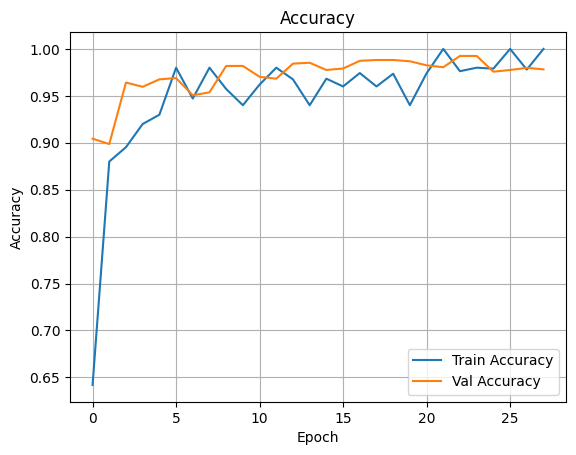

In [14]:
# Plotting
plt.figure()
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.show()


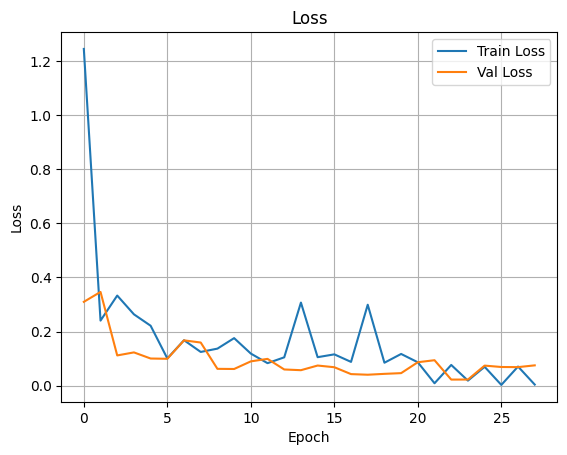

In [15]:
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

###Model Evaluation & Predictions

In [30]:
# --- Print Final Accuracy and Loss ---

# Training metrics (last epoch)
train_acc = history.history['categorical_accuracy'][-1]
train_loss = history.history['loss'][-1]

# Validation metrics (last epoch)
val_acc = history.history['val_categorical_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

# Test metrics (evaluation)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

In [31]:
# Print in formatted table
print("\n=== Final Accuracy and Loss ===")
print(f"Training   Accuracy: {train_acc:.4f} | Loss: {train_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f} | Loss: {val_loss:.4f}")
print(f"Test       Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")


=== Final Accuracy and Loss ===
Training   Accuracy: 1.0000 | Loss: 0.0041
Validation Accuracy: 0.9782 | Loss: 0.0751
Test       Accuracy: 0.9756 | Loss: 0.0999


In [17]:
# Predictions
preds = model.predict(X_test)
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(preds, axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [18]:
# Classification Report & Confusion Matrix
print("Classification Report:\n", classification_report(y_true, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        60
           1       0.98      0.98      0.98       720
           2       0.99      0.99      0.99       750
           3       0.99      0.92      0.95       450
           4       0.98      0.98      0.98       660
           5       0.94      0.97      0.96       630
           6       0.99      0.90      0.94       150
           7       0.99      1.00      0.99       450
           8       0.98      0.99      0.99       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.94      0.93      0.94       420
          12       1.00      0.98      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.97      0.99      0.98       210
          16       1.00      1.00      1.00       150
   

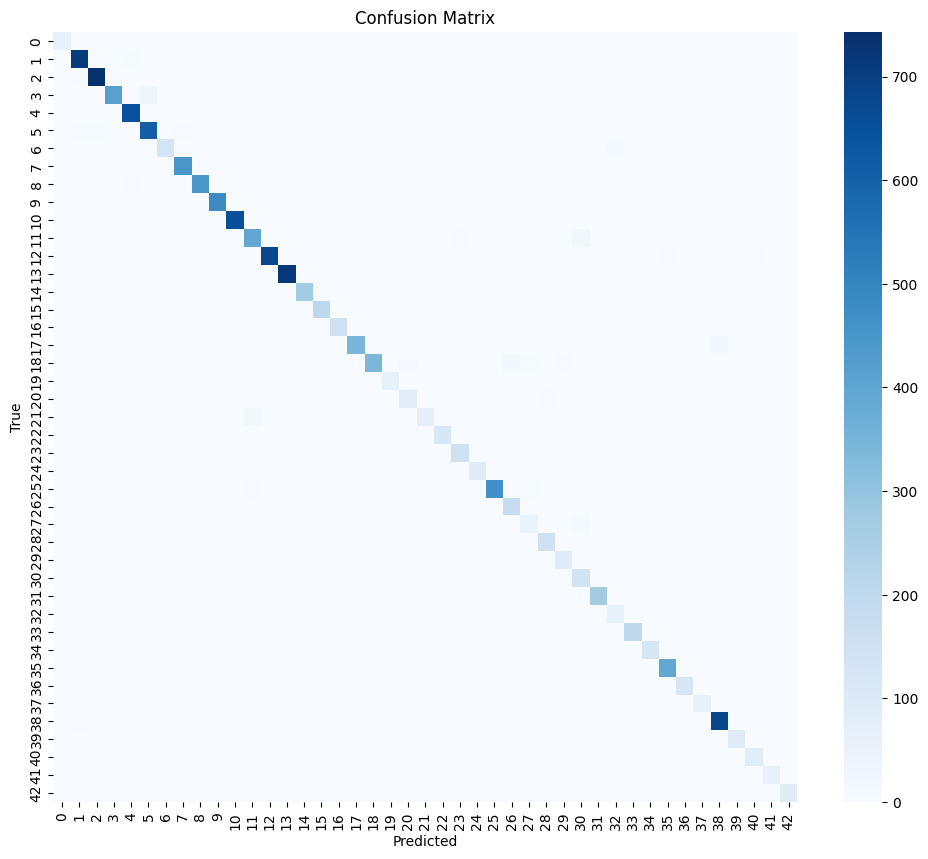

In [19]:
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=False, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

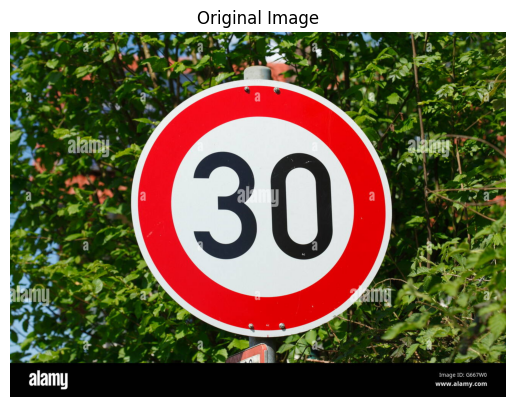

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
Predicted Class ID: 1
Predicted Sign Name: Speed limit (30km/h)


In [20]:
# --- Predict a traffic sign from an external image URL ---
import requests
from PIL import Image

url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)

plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.show()

# Convert image to array and resize
img = np.asarray(img)
img = cv2.resize(img, (32, 32))

# Preprocess the image using same steps
img = preprocess(img)
img = img.reshape(1, 32, 32, 1)

# Make prediction
prediction = model.predict(img)
predicted_class = np.argmax(prediction)
predicted_label = data.loc[predicted_class, 'SignName']

print(f"Predicted Class ID: {predicted_class}")
print(f"Predicted Sign Name: {predicted_label}")

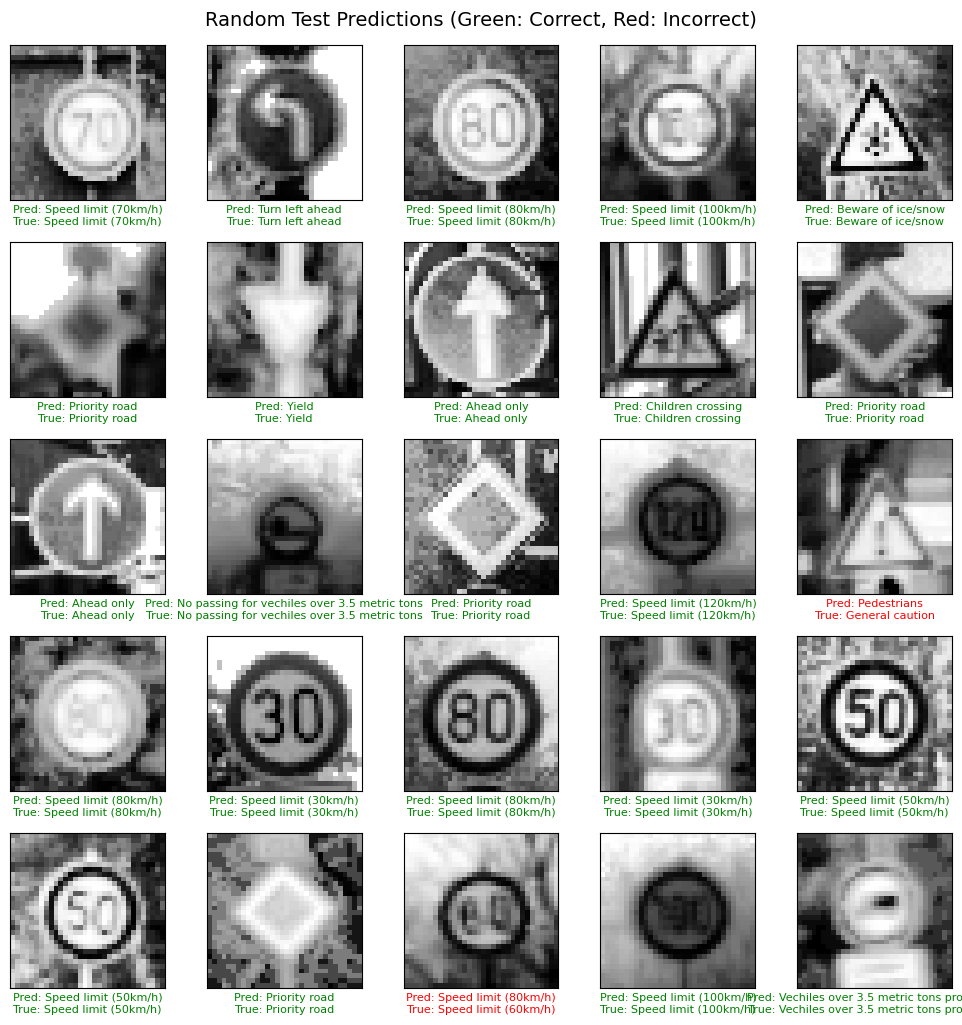

In [27]:
# --- Visualize Random Predictions from Test Set ---
plt.figure(figsize=(10, 10))
start_index = random.randint(0, len(X_test) - 25)
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    pred = np.argmax(preds[start_index + i])
    gt = np.argmax(y_test[start_index + i])

    color = 'g' if pred == gt else 'r'
    pred_label = data.loc[pred, 'SignName']
    gt_label = data.loc[gt, 'SignName']

    plt.xlabel(f"Pred: {pred_label}\nTrue: {gt_label}", color=color, fontsize=8)
    plt.imshow(X_test[start_index + i].reshape(32, 32), cmap='gray')

plt.tight_layout()
plt.suptitle("Random Test Predictions (Green: Correct, Red: Incorrect)", fontsize=14, y=1.02)
plt.show()

###Save the Final Model

In [28]:
# Save final model
final_path = "/content/drive/MyDrive/Projects/Traffic_Sign_Classification/my_model_final.h5"
model.save(final_path)
print(f"Model saved to {final_path}")

Model saved to /content/drive/MyDrive/Projects/Traffic_Sign_Classification/my_model_final.h5
